In [37]:
#!/usr/bin/env python3
"""
Sistema Completo de Aprendizaje por Refuerzo para Brazo Robótico
VERSIÓN PARA JUPYTER NOTEBOOK

Tarea: Voltear un vaso colocado aleatoriamente en el workspace
Basado en el proyecto pybullet_ur5_robotiq original

CONFIGURACIÓN DIRECTA (sin argumentos de línea de comandos):
- Cambia las variables en la sección CONFIGURACIÓN PRINCIPAL
- Ejecuta las celdas correspondientes según el modo deseado
"""

import os
import math
import random
import time
import numpy as np
import pybullet as p
import pybullet_data
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

# Importar clases del proyecto original
try:
    from robot import UR5Robotiq85, Panda
    from utilities import Camera
except ImportError as e:
    print(f"Error importando módulos del proyecto original: {e}")
    print("Asegúrate de estar en el directorio correcto: ~/Documents/INTELIGENCIAS/pybullet_ur5_robotiq")


In [ ]:
# ============================================================================
# CONFIGURACIÓN PRINCIPAL - CAMBIA ESTOS VALORES
# ============================================================================

# CONFIGURACIÓN DEL MODO DE EJECUCIÓN
MODE = "train"  # Opciones: "train", "demo", "manual"
ROBOT_TYPE = "ur5"  # Opciones: "ur5", "panda"
NUM_EPISODES = 1000  # Número de episodios para entrenamiento
RENDER = True  # True para visualización, False para entrenamiento rápido
MODEL_PATH = "best_model.pth"  # Ruta del modelo para demostración

print(f"   Configuración actual:")
print(f"   Modo: {MODE}")
print(f"   Robot: {ROBOT_TYPE}")
print(f"   Episodios: {NUM_EPISODES}")
print(f"   Render: {RENDER}")


🤖 Configuración actual:
   Modo: train
   Robot: ur5
   Episodios: 1000
   Render: True


In [39]:
# ============================================================================
# UTILIDADES PARA MANEJAR PYBULLET EN JUPYTER
# ============================================================================

def disconnect_all_pybullet():
    """Desconecta todas las conexiones activas de PyBullet."""
    try:
        p.disconnect()
        print("🔌 Conexiones PyBullet desconectadas")
    except:
        pass  # No hay conexiones activas

def safe_pybullet_connect(render_mode=None):
    """Conecta a PyBullet de manera segura, manejando conexiones existentes."""
    try:
        # Intentar desconectar primero
        disconnect_all_pybullet()
        
        # Conectar según el modo
        if render_mode == "human":
            physics_client = p.connect(p.GUI)
            p.configureDebugVisualizer(p.COV_ENABLE_GUI, 1)
            print("🖥️ PyBullet conectado en modo GUI")
        else:
            physics_client = p.connect(p.DIRECT)
            print("🔧 PyBullet conectado en modo DIRECT")
            
        return physics_client
        
    except Exception as e:
        print(f"⚠️ Error conectando PyBullet: {e}")
        # Como fallback, usar modo DIRECT
        try:
            physics_client = p.connect(p.DIRECT)
            print("🔧 Fallback: PyBullet conectado en modo DIRECT")
            return physics_client
        except:
            raise Exception("No se pudo conectar a PyBullet")


In [40]:

# ============================================================================
# CONFIGURACIÓN Y CONSTANTES
# ============================================================================

class Config:
    """Configuración del entrenamiento y entorno."""
    
    # Entorno
    MAX_EPISODE_STEPS = 200
    WORKSPACE_SIZE = 1.0  # 1 metro como especifica la tarea
    SIMULATION_STEP_DELAY = 1/240.0
    
    # PPO Hyperparameters
    LEARNING_RATE = 3e-4
    GAMMA = 0.99
    EPS_CLIP = 0.2
    K_EPOCHS = 10
    BUFFER_SIZE = 2048
    ENTROPY_COEF = 0.01
    VALUE_COEF = 0.5
    MAX_GRAD_NORM = 0.5
    
    # Entrenamiento
    MAX_EPISODES = NUM_EPISODES
    EVAL_INTERVAL = 100
    SAVE_INTERVAL = 500
    LOG_INTERVAL = 10
    
    # Recompensas
    REWARD_SUCCESS = 100.0
    REWARD_DROP_PENALTY = -50.0
    REWARD_PROXIMITY = 5.0
    REWARD_CONTACT = 10.0
    REWARD_MOVEMENT = 15.0
    REWARD_TIME_PENALTY = -0.1



In [41]:
# ============================================================================
# ENTORNO DE APRENDIZAJE POR REFUERZO
# ============================================================================

class CupFlipEnvironment:
    """Entorno de RL para que el brazo robótico aprenda a voltear un vaso."""
    
    def __init__(self, robot_type="ur5", render_mode=None, config=None):
        self.config = config or Config()
        self.render_mode = render_mode
        self.current_step = 0
        
        # Configuración del workspace
        self.workspace_bounds = {
            'x': [-self.config.WORKSPACE_SIZE/2, self.config.WORKSPACE_SIZE/2],
            'y': [0.3, 0.8],
            'z': [0.0, 0.5]
        }
        
        # Inicializar PyBullet
        self._setup_physics()
        
        # Inicializar robot
        self.robot_type = robot_type
        self._setup_robot()
        
        # Configurar cámara
        self._setup_camera()
        
        # Variables de estado
        self.cup_id = None
        self.cup_initial_pos = None
        self.cup_flipped = False
        self.cup_dropped = False
        self.contact_made = False
        
        # Métricas
        self.episode_rewards = []
        self.success_count = 0
        self.total_episodes = 0
        
        print(f"✅ Entorno CupFlip inicializado con robot {robot_type}")
        
    def _setup_physics(self):
        """Configura el entorno de física PyBullet."""
        # Usar conexión segura
        self.physics_client = safe_pybullet_connect(self.render_mode)
            
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.81)
        p.setTimeStep(self.config.SIMULATION_STEP_DELAY)
        p.setRealTimeSimulation(0)
        
        # Cargar plano
        self.plane_id = p.loadURDF("plane.urdf")
        p.changeVisualShape(self.plane_id, -1, rgbaColor=[0.8, 0.8, 0.8, 1.0])
        
    def _setup_robot(self):
        """Configura el robot según el tipo especificado."""
        if self.robot_type.lower() == "ur5":
            self.robot = UR5Robotiq85((0, 0, 0), (0, 0, 0))
        elif self.robot_type.lower() == "panda":
            self.robot = Panda((0, 0.5, 0), (0, 0, math.pi))
        else:
            raise ValueError(f"Tipo de robot no soportado: {self.robot_type}")
            
        self.robot.load()
        self.robot.step_simulation = self._step_simulation
        
        # Dimensiones
        self.action_dim = 7  # 6 articulaciones + gripper
        self.state_dim = 88  # Calculado previamente
        
    def _setup_camera(self):
        """Configura la cámara para percepción visual."""
        self.camera = Camera(
            cam_pos=[0.8, 0.0, 0.8],
            cam_tar=[0.0, 0.5, 0.1],
            cam_up_vector=[0, 0, 1],
            near=0.1,
            far=2.0,
            size=(84, 84),
            fov=60
        )
        
    def _step_simulation(self):
        """Hook para el paso de simulación."""
        p.stepSimulation()
        if self.render_mode == "human":
            time.sleep(self.config.SIMULATION_STEP_DELAY)
            
    def _spawn_cup(self):
        """Genera un vaso en posición aleatoria."""
        x = random.uniform(self.workspace_bounds['x'][0], self.workspace_bounds['x'][1])
        y = random.uniform(self.workspace_bounds['y'][0], self.workspace_bounds['y'][1])
        z = 0.05
        
        yaw = random.uniform(0, 2 * math.pi)
        orientation = p.getQuaternionFromEuler([0, 0, yaw])
        
        self.cup_initial_pos = [x, y, z]
        
        # Crear vaso
        cup_collision = p.createCollisionShape(shapeType=p.GEOM_CYLINDER, radius=0.03, height=0.08)
        cup_visual = p.createVisualShape(shapeType=p.GEOM_CYLINDER, radius=0.03, length=0.08, rgbaColor=[0.8, 0.2, 0.2, 1.0])
        
        self.cup_id = p.createMultiBody(
            baseMass=0.1,
            baseCollisionShapeIndex=cup_collision,
            baseVisualShapeIndex=cup_visual,
            basePosition=self.cup_initial_pos,
            baseOrientation=orientation
        )
        
        p.changeDynamics(self.cup_id, -1, lateralFriction=0.8, spinningFriction=0.3, rollingFriction=0.1, restitution=0.2)
        
    def _get_observation(self):
        """Obtiene el estado actual del entorno."""
        obs = []
        
        # Estado del robot
        joint_obs = self.robot.get_joint_obs()
        obs.extend(joint_obs['positions'][:6])  # 6 articulaciones
        obs.extend(joint_obs['ee_pos'])  # 3 posición EE
        
        # Orientación EE
        ee_state = p.getLinkState(self.robot.id, self.robot.eef_id)
        obs.extend(ee_state[1])  # 4 quaternion
        
        # Estado del vaso
        if self.cup_id is not None:
            cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cup_id)
            obs.extend(cup_pos)   # 3
            obs.extend(cup_orn)   # 4
        else:
            obs.extend([0.0] * 7)
            
        # Información visual
        try:
            rgb, depth, seg = self.camera.shot()
            visual_features = self._process_visual_input(rgb)
            obs.extend(visual_features)  # 64
        except Exception as e:
            print(f"Error procesando imagen: {e}")
            # Usar características visuales por defecto
            obs.extend([0.0] * 64)
        
        # Distancia robot-vaso
        if self.cup_id is not None:
            cup_pos_arr = np.array(cup_pos)
            ee_pos_arr = np.array(joint_obs['ee_pos'])
            distance = np.linalg.norm(ee_pos_arr - cup_pos_arr)
            obs.append(distance)
        else:
            obs.append(1.0)
            
        # Estado gripper
        gripper_state = joint_obs['positions'][6] if len(joint_obs['positions']) > 6 else 0.0
        obs.append(gripper_state)
        
        # Banderas de estado
        obs.append(float(self.contact_made))
        obs.append(float(self.cup_flipped))
        
        return np.array(obs, dtype=np.float32)
    
    def _process_visual_input(self, rgb):
        """Procesa imagen para extraer características."""
        try:
            # Convertir a numpy array si no lo es
            if not isinstance(rgb, np.ndarray):
                rgb = np.array(rgb)
            
            # Verificar dimensiones
            if len(rgb.shape) == 4:  # (width, height, channels, alpha)
                rgb = rgb[:, :, :3]  # Tomar solo RGB
            elif len(rgb.shape) == 3 and rgb.shape[2] > 3:
                rgb = rgb[:, :, :3]  # Tomar solo RGB
            elif len(rgb.shape) == 3 and rgb.shape[2] == 3:
                pass  # Ya está en formato correcto
            elif len(rgb.shape) == 2:
                # Ya es escala de grises
                gray = rgb
            else:
                # Formato desconocido, usar valores por defecto
                return [0.0] * 64
            
            # Convertir a escala de grises si es necesario
            if len(rgb.shape) == 3:
                gray = cv2.cvtColor(rgb.astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                gray = rgb.astype(np.uint8)
            
            # Redimensionar y normalizar
            resized = cv2.resize(gray, (8, 8))
            normalized = resized.astype(np.float32) / 255.0
            return normalized.flatten().tolist()
            
        except Exception as e:
            print(f"Error en procesamiento visual: {e}")
            # Retornar características por defecto en caso de error
            return [0.0] * 64
    
    def _check_contact(self):
        """Verifica contacto robot-vaso."""
        if self.cup_id is None:
            return False
        contact_points = p.getContactPoints(bodyA=self.robot.id, bodyB=self.cup_id)
        return len(contact_points) > 0
    
    def _is_cup_flipped(self):
        """Verifica si el vaso está volteado."""
        if self.cup_id is None:
            return False
        _, cup_orn = p.getBasePositionAndOrientation(self.cup_id)
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        tilt_angle = abs(cup_euler[0]) + abs(cup_euler[1])
        return tilt_angle > math.pi/4
    
    def _is_cup_dropped(self):
        """Verifica si el vaso se cayó."""
        if self.cup_id is None:
            return True
        cup_pos, _ = p.getBasePositionAndOrientation(self.cup_id)
        margin = 0.2
        return (cup_pos[2] < -0.1 or
                cup_pos[0] < self.workspace_bounds['x'][0] - margin or
                cup_pos[0] > self.workspace_bounds['x'][1] + margin or
                cup_pos[1] < self.workspace_bounds['y'][0] - margin or
                cup_pos[1] > self.workspace_bounds['y'][1] + margin)
    
    def _calculate_reward(self):
        """Calcula recompensa del estado actual."""
        reward = 0.0
        done = False
        info = {'cup_flipped': False, 'cup_dropped': False, 'contact_made': False, 'success': False, 'distance_to_cup': 0.0}
        
        if self.cup_id is None:
            return self.config.REWARD_DROP_PENALTY, True, info
        
        # Obtener posiciones
        cup_pos, _ = p.getBasePositionAndOrientation(self.cup_id)
        ee_pos = np.array(self.robot.get_joint_obs()['ee_pos'])
        cup_pos_arr = np.array(cup_pos)
        distance = np.linalg.norm(ee_pos - cup_pos_arr)
        info['distance_to_cup'] = distance
        
        # Verificar contacto
        if self._check_contact() and not self.contact_made:
            self.contact_made = True
            reward += self.config.REWARD_CONTACT
            info['contact_made'] = True
        
        # Verificar si se cayó
        if self._is_cup_dropped():
            self.cup_dropped = True
            info['cup_dropped'] = True
            reward += self.config.REWARD_DROP_PENALTY
            done = True
            return reward, done, info
        
        # Verificar si está volteado (¡ÉXITO!)
        if self._is_cup_flipped():
            if not self.cup_flipped:
                self.cup_flipped = True
                info['cup_flipped'] = True
                info['success'] = True
                reward += self.config.REWARD_SUCCESS
                done = True
                return reward, done, info
        
        # Recompensas progresivas
        max_distance = 1.5
        proximity_reward = max(0, (max_distance - distance) / max_distance) * self.config.REWARD_PROXIMITY
        reward += proximity_reward
        
        # Movimiento del vaso
        cup_displacement = np.linalg.norm(cup_pos_arr - np.array(self.cup_initial_pos))
        if cup_displacement > 0.02:
            reward += self.config.REWARD_MOVEMENT
        
        # Penalización por tiempo
        reward += self.config.REWARD_TIME_PENALTY
        
        # Límite de pasos
        if self.current_step >= self.config.MAX_EPISODE_STEPS:
            done = True
            
        return reward, done, info
    
    def step(self, action):
        """Ejecuta un paso en el entorno."""
        self.current_step += 1
        
        # Mapear acción a comandos del robot
        robot_commands = self._map_action_to_robot(action)
        
        # Ejecutar en robot
        try:
            self.robot.move_ee(robot_commands[:-1], 'joint')
            self.robot.move_gripper(robot_commands[-1])
        except Exception as e:
            pass  # Continuar silenciosamente en caso de error
        
        # Simular física
        for _ in range(10):
            self._step_simulation()
        
        # Obtener nuevo estado y recompensa
        observation = self._get_observation()
        reward, done, info = self._calculate_reward()
        
        return observation, reward, done, info
    
    def _map_action_to_robot(self, action):
        """Mapea acciones [-1,1] a comandos del robot."""
        arm_limits_low = np.array(self.robot.arm_lower_limits)
        arm_limits_high = np.array(self.robot.arm_upper_limits)
        
        arm_actions = arm_limits_low + (action[:6] + 1) * 0.5 * (arm_limits_high - arm_limits_low)
        gripper_action = (action[6] + 1) * 0.5 * self.robot.gripper_range[1]
        
        return np.concatenate([arm_actions, [gripper_action]])
    
    def reset(self):
        """Reinicia el entorno."""
        self.current_step = 0
        self.cup_flipped = False
        self.cup_dropped = False
        self.contact_made = False
        
        if self.cup_id is not None:
            p.removeBody(self.cup_id)
            
        self.robot.reset()
        self._spawn_cup()
        
        for _ in range(50):
            self._step_simulation()
        
        self.total_episodes += 1
        return self._get_observation()
    
    def close(self):
        """Cierra el entorno."""
        if hasattr(self, 'physics_client'):
            p.disconnect(self.physics_client)


In [ ]:
# ============================================================================
# AGENTE PPO (versión simplificada)
# ============================================================================

class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2), nn.ReLU()
        )
        
        self.actor_mean = nn.Sequential(nn.Linear(hidden_dim//2, action_dim), nn.Tanh())
        self.actor_logstd = nn.Parameter(torch.zeros(action_dim))
        self.critic = nn.Sequential(nn.Linear(hidden_dim//2, 1))
        
    def forward(self, state):
        shared_features = self.shared(state)
        action_mean = self.actor_mean(shared_features)
        action_std = torch.exp(self.actor_logstd.expand_as(action_mean))
        state_value = self.critic(shared_features)
        return action_mean, action_std, state_value
    
    def act(self, state, deterministic=False):
        with torch.no_grad():
            action_mean, action_std, state_value = self.forward(state)
            if deterministic:
                action = action_mean
                log_prob = None
            else:
                dist = Normal(action_mean, action_std)
                action = dist.sample()
                log_prob = dist.log_prob(action).sum(dim=-1)
                action = torch.clamp(action, -1.0, 1.0)
        return action, log_prob, state_value
    
    def evaluate_actions(self, states, actions):
        """Evalúa acciones para el entrenamiento PPO."""
        action_mean, action_std, state_values = self.forward(states)
        
        # Crear distribución
        dist = Normal(action_mean, action_std)
        
        # Calcular log probabilidades
        log_probs = dist.log_prob(actions).sum(dim=-1)
        
        # Calcular entropía
        entropy = dist.entropy().sum(dim=-1)
        
        return log_probs, state_values.squeeze(), entropy


class PPOAgent:
    def __init__(self, state_dim, action_dim, config=None):
        self.config = config or Config()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.policy = ActorCriticNetwork(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.config.LEARNING_RATE)
        self.buffer = PPOBuffer(self.config.BUFFER_SIZE, state_dim, action_dim)
        
        self.training_step = 0
        self.episode_rewards = deque(maxlen=100)
        
        print(f"✅ PPO Agent inicializado en {self.device}")
        
    def select_action(self, state, deterministic=False):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action, log_prob, state_value = self.policy.act(state_tensor, deterministic)
        return (action.cpu().numpy().flatten(),
                log_prob.cpu().item() if log_prob is not None else None,
                state_value.cpu().item())
    
    def store_transition(self, state, action, reward, next_state, done, log_prob, value):
        self.buffer.store(state, action, reward, next_state, done, log_prob, value)
    
    def update(self):
        if not self.buffer.is_ready():
            return {}
        
        states, actions, rewards, next_states, dones, old_log_probs, values = self.buffer.get()
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(self.device)
        
        advantages, returns = self._compute_gae(rewards, values, dones)
        advantages = torch.FloatTensor(advantages).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        policy_losses = []
        value_losses = []
        
        for _ in range(self.config.K_EPOCHS):
            new_log_probs, new_values, entropy = self.policy.evaluate_actions(states, actions)
            
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.config.EPS_CLIP, 1 + self.config.EPS_CLIP) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            value_loss = F.mse_loss(new_values, returns)
            total_loss = policy_loss + self.config.VALUE_COEF * value_loss - self.config.ENTROPY_COEF * entropy.mean()
            
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.config.MAX_GRAD_NORM)
            self.optimizer.step()
            
            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())
        
        self.buffer.clear()
        self.training_step += 1
        
        return {'policy_loss': np.mean(policy_losses), 'value_loss': np.mean(value_losses)}
    
    def evaluate_actions(self, states, actions):
        action_mean, action_std, state_values = self.policy.forward(states)
        dist = Normal(action_mean, action_std)
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, state_values.squeeze(), entropy
    
    def _compute_gae(self, rewards, values, dones, gae_lambda=0.95):
        advantages = np.zeros_like(rewards)
        returns = np.zeros_like(rewards)
        gae = 0
        
        for step in reversed(range(len(rewards))):
            if step == len(rewards) - 1:
                next_non_terminal = 1.0 - dones[step]
                next_value = 0
            else:
                next_non_terminal = 1.0 - dones[step]
                next_value = values[step + 1]
            
            delta = rewards[step] + self.config.GAMMA * next_value * next_non_terminal - values[step]
            gae = delta + self.config.GAMMA * gae_lambda * next_non_terminal * gae
            advantages[step] = gae
            returns[step] = advantages[step] + values[step]
        
        return advantages, returns
    
    def save_model(self, filepath):
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'training_step': self.training_step
        }, filepath)
        print(f"💾 Modelo guardado: {filepath}")
    
    def load_model(self, filepath):
        try:
            checkpoint = torch.load(filepath, map_location=self.device)
            self.policy.load_state_dict(checkpoint['policy_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.training_step = checkpoint['training_step']
            print(f"📂 Modelo cargado: {filepath}")
            return True
        except Exception as e:
            print(f" Error cargando modelo: {e}")
            return False


class PPOBuffer:
    def __init__(self, buffer_size, state_dim, action_dim):
        self.buffer_size = buffer_size
        self.current_size = 0
        
        self.states = np.zeros((buffer_size, state_dim))
        self.actions = np.zeros((buffer_size, action_dim))
        self.rewards = np.zeros(buffer_size)
        self.next_states = np.zeros((buffer_size, state_dim))
        self.dones = np.zeros(buffer_size)
        self.log_probs = np.zeros(buffer_size)
        self.values = np.zeros(buffer_size)
        
    def store(self, state, action, reward, next_state, done, log_prob, value):
        idx = self.current_size % self.buffer_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.log_probs[idx] = log_prob if log_prob is not None else 0
        self.values[idx] = value
        self.current_size += 1
    
    def get(self):
        size = min(self.current_size, self.buffer_size)
        return (self.states[:size], self.actions[:size], self.rewards[:size],
                self.next_states[:size], self.dones[:size], 
                self.log_probs[:size], self.values[:size])
    
    def is_ready(self):
        return self.current_size >= self.buffer_size
    
    def clear(self):
        self.current_size = 0


In [ ]:
# ============================================================================
# FUNCIONES DE DIAGNÓSTICO Y PRUEBA
# ============================================================================

def test_environment(robot_type="ur5"):
    """Función para probar el entorno antes del entrenamiento."""
    print("🔍 PRUEBA DEL ENTORNO")
    print("=" * 40)
    
    try:
        # Limpiar conexiones existentes
        print("0️ Limpiando conexiones PyBullet existentes...")
        disconnect_all_pybullet()
        
        # Crear entorno
        print("1️ Creando entorno...")
        env = CupFlipEnvironment(
            robot_type=robot_type,
            render_mode=None,  # Usar modo DIRECT para pruebas
            config=Config()
        )
        print(f" Entorno creado exitosamente")
        print(f"   Estado: {env.state_dim}D")
        print(f"   Acciones: {env.action_dim}D")
        
        # Probar reset
        print("\n2️ Probando reset...")
        state = env.reset()
        print(f" Reset exitoso - Estado shape: {state.shape}")
        
        # Probar acción aleatoria
        print("\n3️ Probando acción aleatoria...")
        random_action = np.random.uniform(-1, 1, env.action_dim)
        next_state, reward, done, info = env.step(random_action)
        print(f" Paso exitoso - Recompensa: {reward:.3f}")
        print(f"   Estado siguiente shape: {next_state.shape}")
        print(f"   Info: {info}")
        
        # Probar cámara
        print("\n4️ Probando cámara...")
        try:
            rgb, depth, seg = env.camera.shot()
            print(f" Cámara funcionando")
            print(f"   RGB type: {type(rgb)}, shape: {getattr(rgb, 'shape', 'N/A')}")
            print(f"   Depth type: {type(depth)}, shape: {getattr(depth, 'shape', 'N/A')}")
        except Exception as e:
            print(f" Problema con cámara: {e}")
        
        # Probar procesamiento visual
        print("\n5️⃣ Probando procesamiento visual...")
        try:
            visual_features = env._process_visual_input(rgb)
            print(f" Procesamiento visual exitoso - {len(visual_features)} características")
        except Exception as e:
            print(f" Problema con procesamiento visual: {e}")
        
        print("\n6️ Probando 10 pasos...")
        for i in range(10):
            action = np.random.uniform(-1, 1, env.action_dim)
            state, reward, done, info = env.step(action)
            print(f"   Paso {i+1}: reward={reward:.3f}, done={done}")
            if done:
                print("   ↳ Episodio terminado, reseteando...")
                state = env.reset()
        
        print("\n TODAS LAS PRUEBAS EXITOSAS")
        print(" El entorno está listo para entrenamiento")
        
        env.close()
        return True
        
    except Exception as e:
        print(f"\n ERROR EN PRUEBAS: {e}")
        print(" Revisa la instalación de dependencias")
        import traceback
        traceback.print_exc()
        return False


def quick_training_test(robot_type="ur5", episodes=5):
    """Prueba rápida de entrenamiento con pocos episodios."""
    print(" PRUEBA RÁPIDA DE ENTRENAMIENTO")
    print("=" * 50)
    
    try:
        # Limpiar conexiones existentes
        disconnect_all_pybullet()
        
        # Crear entorno y agente
        env = CupFlipEnvironment(
            robot_type=robot_type,
            render_mode=None,  # Modo DIRECT para pruebas
            config=Config()
        )
        
        agent = PPOAgent(
            state_dim=env.state_dim,
            action_dim=env.action_dim,
            config=Config()
        )
        
        print(f" Sistema inicializado para {episodes} episodios de prueba")
        
        for episode in range(episodes):
            print(f"\n📋 Episodio {episode + 1}/{episodes}")
            
            state = env.reset()
            episode_reward = 0
            steps = 0
            done = False
            
            while not done and steps < 50:  # Máximo 50 pasos por episodio
                action, log_prob, value = agent.select_action(state)
                next_state, reward, done, info = env.step(action)
                
                agent.store_transition(state, action, reward, next_state, done, log_prob, value)
                
                episode_reward += reward
                steps += 1
                state = next_state
                
                # Actualizar agente si hay suficientes experiencias
                if agent.buffer.is_ready():
                    metrics = agent.update()
                    if metrics:
                        print(f"   ↳ Actualización PPO: loss={metrics.get('policy_loss', 0):.4f}")
            
            print(f"   Resultado: reward={episode_reward:.2f}, steps={steps}")
            print(f"   Éxito: {info.get('success', False)}, Vaso volteado: {info.get('cup_flipped', False)}")
        
        print("\n PRUEBA DE ENTRENAMIENTO EXITOSA")
        print(" Sistema listo para entrenamiento completo")
        
        env.close()
        return True
        
    except Exception as e:
        print(f"\n ERROR EN PRUEBA DE ENTRENAMIENTO: {e}")
        import traceback
        traceback.print_exc()
        return False

In [ ]:
# ============================================================================
# FUNCIONES PRINCIPALES PARA JUPYTER (ACTUALIZADAS)
# ============================================================================

def run_training(robot_type=ROBOT_TYPE, num_episodes=NUM_EPISODES, render=RENDER):
    """Función principal para entrenamiento."""
    print(" INICIANDO ENTRENAMIENTO")
    print("=" * 50)
    
    # Inicializar entorno y agente
    env = CupFlipEnvironment(
        robot_type=robot_type,
        render_mode="human" if render else None,
        config=Config()
    )
    
    agent = PPOAgent(
        state_dim=env.state_dim,
        action_dim=env.action_dim,
        config=Config()
    )
    
    # Métricas
    episode_rewards = []
    success_rates = []
    recent_rewards = deque(maxlen=100)
    recent_successes = deque(maxlen=100)
    best_reward = -np.inf
    
    # Entrenamiento
    pbar = tqdm(range(num_episodes), desc="Entrenamiento")
    
    for episode in pbar:
        # Entrenar episodio
        state = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        while not done and episode_length < Config.MAX_EPISODE_STEPS:
            action, log_prob, value = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            
            agent.store_transition(state, action, reward, next_state, done, log_prob, value)
            
            episode_reward += reward
            episode_length += 1
            state = next_state
            
            if agent.buffer.is_ready():
                metrics = agent.update()
        
        # Actualizar métricas
        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)
        recent_successes.append(info.get('success', False))
        
        # Logging
        if episode % 10 == 0:
            avg_reward = np.mean(recent_rewards)
            success_rate = np.mean(recent_successes)
            
            pbar.set_postfix({
                'Reward': f'{avg_reward:.2f}',
                'Success': f'{success_rate:.2%}',
                'Best': f'{best_reward:.2f}'
            })
            
            if avg_reward > best_reward:
                best_reward = avg_reward
                agent.save_model('best_model.pth')
        
        # Evaluación periódica
        if episode % 100 == 0 and episode > 0:
            eval_rewards = []
            eval_successes = []
            
            for _ in range(5):  # 5 episodios de evaluación
                state = env.reset()
                episode_reward = 0
                done = False
                ep_length = 0
                
                while not done and ep_length < Config.MAX_EPISODE_STEPS:
                    action, _, _ = agent.select_action(state, deterministic=True)
                    state, reward, done, info = env.step(action)
                    episode_reward += reward
                    ep_length += 1
                
                eval_rewards.append(episode_reward)
                eval_successes.append(info.get('success', False))
            
            print(f"\n📊 Evaluación episodio {episode}:")
            print(f"   Recompensa promedio: {np.mean(eval_rewards):.2f}")
            print(f"   Tasa de éxito: {np.mean(eval_successes):.2%}")
            
            success_rates.append(np.mean(eval_successes))
        
        # Guardar checkpoint
        if episode % 500 == 0 and episode > 0:
            agent.save_model(f'checkpoint_episode_{episode}.pth')
    
    print("\n ¡Entrenamiento completado!")
    agent.save_model('final_model.pth')
    
    # Cerrar entorno
    env.close()
    
    # Graficar resultados
    plot_training_results(episode_rewards, success_rates)
    
    return episode_rewards, success_rates


def run_demo(model_path=MODEL_PATH, robot_type=ROBOT_TYPE, num_demos=3):
    """Función para demostración del modelo entrenado."""
    print(" INICIANDO DEMOSTRACIÓN")
    print("=" * 50)
    
    # Inicializar entorno y agente
    env = CupFlipEnvironment(
        robot_type=robot_type,
        render_mode="human",
        config=Config()
    )
    
    agent = PPOAgent(
        state_dim=env.state_dim,
        action_dim=env.action_dim,
        config=Config()
    )
    
    # Cargar modelo
    if not agent.load_model(model_path):
        print(f" No se pudo cargar el modelo: {model_path}")
        print(" Entrena primero un modelo usando run_training()")
        return
    
    print(f"🎬 Ejecutando {num_demos} demostraciones...")
    
    for demo in range(num_demos):
        print(f"\n--- Demostración {demo + 1} ---")
        state = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        while not done and episode_length < 500:
            action, _, _ = agent.select_action(state, deterministic=True)
            state, reward, done, info = env.step(action)
            episode_reward += reward
            episode_length += 1
            
            time.sleep(0.05)  # Para mejor visualización
        
        print(f" Recompensa: {episode_reward:.2f}")
        print(f" Longitud: {episode_length}")
        print(f" Éxito: {info.get('success', False)}")
        print(f" Vaso volteado: {info.get('cup_flipped', False)}")
        print(f" Vaso caído: {info.get('cup_dropped', False)}")
        
        if demo < num_demos - 1:
            input("  Presiona Enter para continuar...")
    
    env.close()
    print(" Demostración completada")


def run_manual_control(robot_type=ROBOT_TYPE):
    """Función para control manual del robot."""
    print(" INICIANDO CONTROL MANUAL")
    print("=" * 50)
    print(" Instrucciones:")
    print("   - Usa los sliders de PyBullet para controlar el robot")
    print("   - Prueba diferentes movimientos para entender la tarea")
    print("   - Presiona Ctrl+C en la consola para salir")
    
    # Inicializar entorno
    env = CupFlipEnvironment(
        robot_type=robot_type,
        render_mode="human",
        config=Config()
    )
    
    # Configurar sliders de debug
    xin = p.addUserDebugParameter("x", -0.5, 0.5, 0)
    yin = p.addUserDebugParameter("y", 0.3, 0.8, 0.5)
    zin = p.addUserDebugParameter("z", 0, 0.5, 0.3)
    rollId = p.addUserDebugParameter("roll", -3.14, 3.14, 0)
    pitchId = p.addUserDebugParameter("pitch", -3.14, 3.14, np.pi/2)
    yawId = p.addUserDebugParameter("yaw", -np.pi/2, np.pi/2, np.pi/2)
    gripper_control = p.addUserDebugParameter("gripper", 0, 0.085, 0.04)
    
    # Resetear entorno
    env.reset()
    
    try:
        print(" Control manual activo. Usa los sliders para mover el robot.")
        step_count = 0
        
        while True:
            # Leer parámetros de debug
            x = p.readUserDebugParameter(xin)
            y = p.readUserDebugParameter(yin)
            z = p.readUserDebugParameter(zin)
            roll = p.readUserDebugParameter(rollId)
            pitch = p.readUserDebugParameter(pitchId)
            yaw = p.readUserDebugParameter(yawId)
            gripper_opening = p.readUserDebugParameter(gripper_control)
            
            # Crear acción manual
            action = [x, y, z, roll, pitch, yaw, gripper_opening]
            
            # Ejecutar acción
            try:
                env.robot.move_ee(action[:-1], 'end')
                env.robot.move_gripper(action[-1])
            except:
                pass
            
            # Simular
            for _ in range(5):
                env._step_simulation()
            
            # Verificar estado del vaso cada 100 pasos
            step_count += 1
            if step_count % 100 == 0:
                if env._is_cup_flipped():
                    print(" ¡Vaso volteado! ¡Excelente!")
                elif env._is_cup_dropped():
                    print(" El vaso se cayó. Reseteando...")
                    env.reset()
                elif env._check_contact():
                    print(" Contacto detectado con el vaso")
            
            time.sleep(0.01)
            
    except KeyboardInterrupt:
        print("\n Saliendo del control manual...")
        env.close()


def plot_training_results(episode_rewards, success_rates):
    """Función para graficar resultados de entrenamiento."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Recompensas por episodio
    axes[0, 0].plot(episode_rewards, alpha=0.7)
    axes[0, 0].set_title('Recompensas por Episodio', fontsize=14)
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Recompensa')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Promedio móvil de recompensas
    if len(episode_rewards) > 100:
        moving_avg = []
        window = 100
        for i in range(window, len(episode_rewards)):
            moving_avg.append(np.mean(episode_rewards[i-window:i]))
        
        axes[0, 1].plot(range(window, len(episode_rewards)), moving_avg, color='red', linewidth=2)
        axes[0, 1].set_title(f'Promedio Móvil de Recompensas ({window} episodios)', fontsize=14)
        axes[0, 1].set_xlabel('Episodio')
        axes[0, 1].set_ylabel('Recompensa Promedio')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Tasa de éxito
    if success_rates:
        eval_episodes = np.arange(0, len(success_rates)) * 100  # Cada 100 episodios
        axes[1, 0].plot(eval_episodes, success_rates, 'go-', linewidth=2, markersize=6)
        axes[1, 0].set_title('Tasa de Éxito en Evaluaciones', fontsize=14)
        axes[1, 0].set_xlabel('Episodio')
        axes[1, 0].set_ylabel('Tasa de Éxito')
        axes[1, 0].set_ylim([0, 1])
        axes[1, 0].grid(True, alpha=0.3)
        
        # Agregar línea de objetivo
        axes[1, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Objetivo 80%')
        axes[1, 0].legend()
    
    # Distribución de recompensas
    axes[1, 1].hist(episode_rewards, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Distribución de Recompensas', fontsize=14)
    axes[1, 1].set_xlabel('Recompensa')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Estadísticas
    mean_reward = np.mean(episode_rewards)
    max_reward = np.max(episode_rewards)
    final_success_rate = success_rates[-1] if success_rates else 0
    
    axes[1, 1].axvline(mean_reward, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_reward:.2f}')
    axes[1, 1].axvline(max_reward, color='green', linestyle='--', linewidth=2, label=f'Máximo: {max_reward:.2f}')
    axes[1, 1].legend()
    
    plt.suptitle(f'Resultados del Entrenamiento - Tasa de Éxito Final: {final_success_rate:.2%}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Gráficas guardadas en 'training_results.png'")
    print(f"📈 Estadísticas finales:")
    print(f"   Recompensa promedio: {mean_reward:.2f}")
    print(f"   Recompensa máxima: {max_reward:.2f}")
    print(f"   Tasa de éxito final: {final_success_rate:.2%}")


In [ ]:
# ============================================================================
# EJECUCIÓN PRINCIPAL PARA JUPYTER
# ============================================================================

def main_jupyter():
    """Función principal adaptada para Jupyter Notebook."""
    print(" SISTEMA DE APRENDIZAJE POR REFUERZO - VOLTEAR VASO")
    print(" Basado en pybullet_ur5_robotiq")
    print("=" * 60)
    print(f" Configuración actual:")
    print(f"   Modo: {MODE}")
    print(f"   Robot: {ROBOT_TYPE}")
    print(f"   Episodios: {NUM_EPISODES}")
    print(f"   Render: {RENDER}")
    print("=" * 60)
    
    # Ejecutar pruebas automáticas antes del entrenamiento
    if MODE == "train":
        print(" Ejecutando pruebas del sistema...")
        if not test_environment(robot_type=ROBOT_TYPE):
            print(" Las pruebas fallaron. Revisa la configuración.")
            return None
        
        print("\n Iniciando entrenamiento...")
        episode_rewards, success_rates = run_training(
            robot_type=ROBOT_TYPE,
            num_episodes=NUM_EPISODES,
            render=RENDER
        )
        return episode_rewards, success_rates
        
    elif MODE == "demo":
        print(" Iniciando demostración...")
        run_demo(
            model_path=MODEL_PATH,
            robot_type=ROBOT_TYPE,
            num_demos=3
        )
        
    elif MODE == "manual":
        print(" Iniciando control manual...")
        run_manual_control(robot_type=ROBOT_TYPE)
    
    elif MODE == "test":
        print(" Ejecutando solo pruebas...")
        test_environment(robot_type=ROBOT_TYPE)
        quick_training_test(robot_type=ROBOT_TYPE, episodes=3)
    
    else:
        print(f" Modo no reconocido: {MODE}")
        print(" Modos válidos: 'train', 'demo', 'manual', 'test'")



🔧 INSTRUCCIONES PARA USAR EN JUPYTER NOTEBOOK:

⚠️ IMPORTANTE - Si hay errores de conexión PyBullet:
   clean_and_restart()  # Ejecuta esto primero

1️⃣ PROBAR EL SISTEMA:
   MODE = "test"
   main_jupyter()  # Ejecuta pruebas automáticas en modo DIRECT

2️⃣ CONFIGURACIÓN BÁSICA:
   MODE = "train"     # "train", "demo", "manual", "test"
   ROBOT_TYPE = "ur5"  # "ur5" o "panda"
   NUM_EPISODES = 50   # Empezar con pocos para probar
   RENDER = False      # False para pruebas, True para ver

3️⃣ ENTRENAMIENTO INICIAL (sin GUI):
   MODE = "train"
   RENDER = False  # Más estable para empezar
   episode_rewards, success_rates = main_jupyter()

4️⃣ ENTRENAMIENTO CON VISUALIZACIÓN:
   clean_and_restart()  # Limpiar primero
   MODE = "train"
   RENDER = True
   episode_rewards, success_rates = main_jupyter()

5️⃣ DEMOSTRACIÓN:
   clean_and_restart()
   MODE = "demo"
   MODEL_PATH = "best_model.pth"
   main_jupyter()

6️⃣ CONTROL MANUAL:
   clean_and_restart()
   MODE = "manual"
   main_jupyte

Entrenamiento:   0%|          | 1/1000 [00:25<7:02:43, 25.39s/it, Reward=321.54, Success=0.00%, Best=-inf]

💾 Modelo guardado: best_model.pth


Entrenamiento:   1%|          | 11/1000 [04:25<6:38:41, 24.19s/it, Reward=682.17, Success=0.00%, Best=321.54]

💾 Modelo guardado: best_model.pth


Entrenamiento:   6%|▌         | 61/1000 [25:30<6:27:26, 24.76s/it, Reward=802.87, Success=3.28%, Best=682.17]

💾 Modelo guardado: best_model.pth


Entrenamiento:   9%|▉         | 91/1000 [37:32<6:00:42, 23.81s/it, Reward=806.45, Success=2.20%, Best=802.87]

💾 Modelo guardado: best_model.pth


Entrenamiento:  10%|█         | 100/1000 [41:31<5:57:06, 23.81s/it, Reward=860.05, Success=2.00%, Best=806.45]

💾 Modelo guardado: best_model.pth


Entrenamiento:  10%|█         | 101/1000 [42:49<11:49:50, 47.38s/it, Reward=860.05, Success=2.00%, Best=806.45]


📊 Evaluación episodio 100:
   Recompensa promedio: 928.57
   Tasa de éxito: 0.00%


Entrenamiento:  11%|█         | 111/1000 [46:48<6:03:56, 24.56s/it, Reward=893.41, Success=2.00%, Best=860.05] 

💾 Modelo guardado: best_model.pth


Entrenamiento:  12%|█▏        | 121/1000 [50:46<5:48:46, 23.81s/it, Reward=1013.83, Success=2.00%, Best=893.41]

💾 Modelo guardado: best_model.pth


Entrenamiento:  13%|█▎        | 131/1000 [54:46<5:46:32, 23.93s/it, Reward=1193.37, Success=1.00%, Best=1013.83]

💾 Modelo guardado: best_model.pth


Entrenamiento:  14%|█▍        | 141/1000 [58:44<5:40:33, 23.79s/it, Reward=1238.76, Success=0.00%, Best=1193.37]

💾 Modelo guardado: best_model.pth


Entrenamiento:  15%|█▌        | 151/1000 [1:02:43<5:38:53, 23.95s/it, Reward=1273.29, Success=0.00%, Best=1238.76]

💾 Modelo guardado: best_model.pth


Entrenamiento:  19%|█▉        | 191/1000 [1:22:51<6:38:14, 29.54s/it, Reward=1309.74, Success=2.00%, Best=1273.29]

💾 Modelo guardado: best_model.pth


Entrenamiento:  20%|██        | 200/1000 [1:28:05<7:03:10, 31.74s/it, Reward=1369.74, Success=2.00%, Best=1309.74]

💾 Modelo guardado: best_model.pth


Entrenamiento:  20%|██        | 201/1000 [1:30:44<17:38:22, 79.48s/it, Reward=1369.74, Success=2.00%, Best=1309.74]


📊 Evaluación episodio 200:
   Recompensa promedio: 2782.24
   Tasa de éxito: 0.00%


Entrenamiento:  28%|██▊       | 281/1000 [2:10:11<4:48:08, 24.05s/it, Reward=1380.45, Success=2.00%, Best=1369.74] 

💾 Modelo guardado: best_model.pth


Entrenamiento:  30%|███       | 301/1000 [2:19:13<8:49:28, 45.45s/it, Reward=1308.50, Success=3.00%, Best=1380.45]


📊 Evaluación episodio 300:
   Recompensa promedio: 954.20
   Tasa de éxito: 0.00%


Entrenamiento:  40%|████      | 401/1000 [3:04:41<9:44:17, 58.53s/it, Reward=1121.42, Success=1.00%, Best=1380.45]


📊 Evaluación episodio 400:
   Recompensa promedio: 1669.71
   Tasa de éxito: 0.00%


Entrenamiento:  47%|████▋     | 471/1000 [3:32:57<3:36:35, 24.57s/it, Reward=1410.98, Success=2.00%, Best=1380.45]

💾 Modelo guardado: best_model.pth


Entrenamiento:  50%|█████     | 501/1000 [3:47:13<8:25:09, 60.74s/it, Reward=1297.43, Success=1.00%, Best=1410.98]


📊 Evaluación episodio 500:
   Recompensa promedio: 1041.07
   Tasa de éxito: 0.00%
💾 Modelo guardado: checkpoint_episode_500.pth


Entrenamiento:  60%|██████    | 600/1000 [4:26:51<2:35:42, 23.36s/it, Reward=1430.25, Success=2.00%, Best=1410.98]

💾 Modelo guardado: best_model.pth


Entrenamiento:  60%|██████    | 601/1000 [4:28:50<6:33:11, 59.13s/it, Reward=1430.25, Success=2.00%, Best=1410.98]


📊 Evaluación episodio 600:
   Recompensa promedio: 1603.54
   Tasa de éxito: 0.00%


Entrenamiento:  65%|██████▌   | 651/1000 [4:54:19<2:59:11, 30.81s/it, Reward=1451.73, Success=3.00%, Best=1430.25]

💾 Modelo guardado: best_model.pth


Entrenamiento:  66%|██████▌   | 661/1000 [4:59:39<3:00:37, 31.97s/it, Reward=1479.13, Success=3.00%, Best=1451.73]

💾 Modelo guardado: best_model.pth


Entrenamiento:  67%|██████▋   | 671/1000 [5:05:02<2:56:33, 32.20s/it, Reward=1529.54, Success=2.00%, Best=1479.13]

💾 Modelo guardado: best_model.pth


Entrenamiento:  68%|██████▊   | 681/1000 [5:10:22<2:50:12, 32.01s/it, Reward=1611.63, Success=1.00%, Best=1529.54]

💾 Modelo guardado: best_model.pth


Entrenamiento:  69%|██████▉   | 691/1000 [5:15:42<2:45:06, 32.06s/it, Reward=1684.38, Success=1.00%, Best=1611.63]

💾 Modelo guardado: best_model.pth


Entrenamiento:  70%|███████   | 700/1000 [5:20:49<2:33:11, 30.64s/it, Reward=1718.18, Success=1.00%, Best=1684.38]

💾 Modelo guardado: best_model.pth


Entrenamiento:  70%|███████   | 701/1000 [5:23:20<6:08:19, 73.91s/it, Reward=1718.18, Success=1.00%, Best=1684.38]


📊 Evaluación episodio 700:
   Recompensa promedio: 1598.93
   Tasa de éxito: 0.00%


Entrenamiento:  71%|███████   | 711/1000 [5:28:13<2:20:48, 29.23s/it, Reward=1746.76, Success=1.00%, Best=1718.18]

💾 Modelo guardado: best_model.pth


Entrenamiento:  80%|████████  | 801/1000 [6:17:08<3:19:50, 60.25s/it, Reward=1200.35, Success=1.00%, Best=1746.76]


📊 Evaluación episodio 800:
   Recompensa promedio: 2216.09
   Tasa de éxito: 0.00%


Entrenamiento:  90%|█████████ | 901/1000 [7:14:58<2:11:46, 79.87s/it, Reward=1167.54, Success=3.00%, Best=1746.76]


📊 Evaluación episodio 900:
   Recompensa promedio: 1053.78
   Tasa de éxito: 0.00%


Entrenamiento: 100%|██████████| 1000/1000 [8:07:42<00:00, 29.26s/it, Reward=1399.10, Success=1.00%, Best=1746.76] 



🎉 ¡Entrenamiento completado!
💾 Modelo guardado: final_model.pth


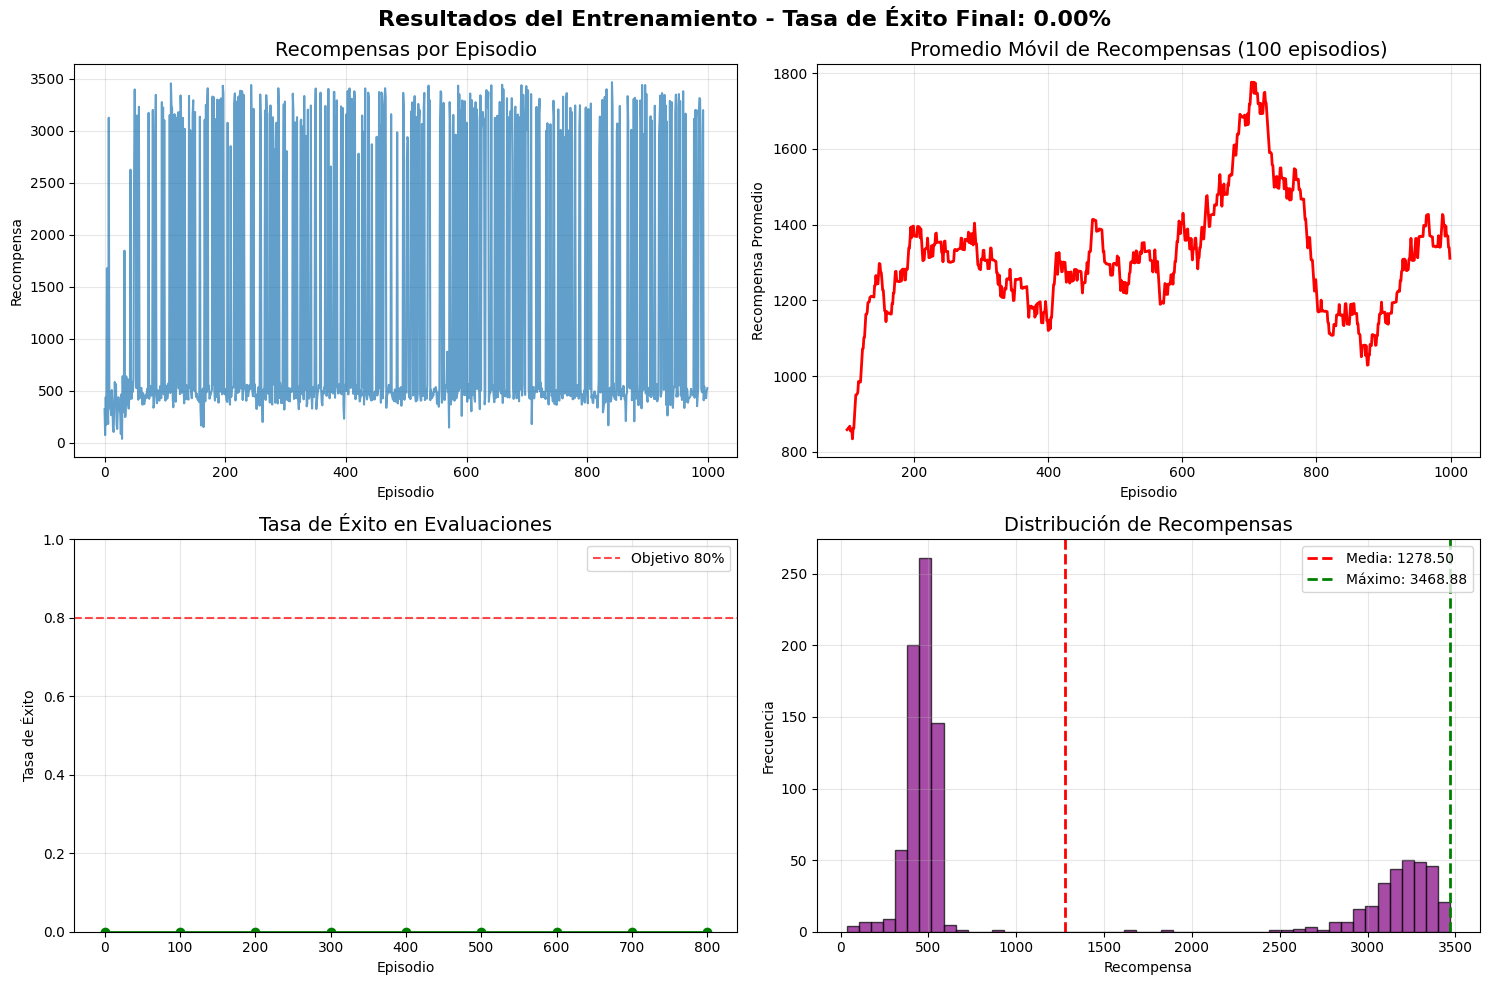

📊 Gráficas guardadas en 'training_results.png'
📈 Estadísticas finales:
   Recompensa promedio: 1278.50
   Recompensa máxima: 3468.88
   Tasa de éxito final: 0.00%


In [ ]:
# ============================================================================
# INSTRUCCIONES ACTUALIZADAS PARA JUPYTER NOTEBOOK
# ============================================================================

def clean_and_restart():
    """Función para limpiar todo y empezar fresh."""
    print(" LIMPIANDO SISTEMA...")
    
    # Desconectar PyBullet
    disconnect_all_pybullet()
    
    # Limpiar cache de PyTorch si es necesario
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(" Sistema limpio - Listo para ejecutar")

print("""
 INSTRUCCIONES PARA USAR EN JUPYTER NOTEBOOK:

 IMPORTANTE - Si hay errores de conexión PyBullet:
   clean_and_restart()  # Ejecuta esto primero

1️ PROBAR EL SISTEMA:
   MODE = "test"
   main_jupyter()  # Ejecuta pruebas automáticas en modo DIRECT

2️ CONFIGURACIÓN BÁSICA:
   MODE = "train"     # "train", "demo", "manual", "test"
   ROBOT_TYPE = "ur5"  # "ur5" o "panda"
   NUM_EPISODES = 50   # Empezar con pocos para probar
   RENDER = False      # False para pruebas, True para ver

3️ ENTRENAMIENTO INICIAL (sin GUI):
   MODE = "train"
   RENDER = False  # Más estable para empezar
   episode_rewards, success_rates = main_jupyter()

4️ ENTRENAMIENTO CON VISUALIZACIÓN:
   clean_and_restart()  # Limpiar primero
   MODE = "train"
   RENDER = True
   episode_rewards, success_rates = main_jupyter()

5️ DEMOSTRACIÓN:
   clean_and_restart()
   MODE = "demo"
   MODEL_PATH = "best_model.pth"
   main_jupyter()

6️ CONTROL MANUAL:
   clean_and_restart()
   MODE = "manual"
   main_jupyter()

 SOLUCIÓN DE PROBLEMAS:
   1. Ejecuta clean_and_restart() antes de cada prueba
   2. Si persisten errores, reinicia el kernel de Jupyter
   3. Usa RENDER = False para pruebas iniciales
   4. Verifica que estés en el directorio correcto

 FUNCIONES ÚTILES:
   # Limpiar sistema
   clean_and_restart()
   
   # Pruebas individuales
   test_environment(robot_type="ur5")
   quick_training_test(robot_type="ur5", episodes=3)
   
   # Desconectar PyBullet manualmente
   disconnect_all_pybullet()

 ¡El robot aprenderá gradualmente a voltear vasos usando PPO!
""")

# Ejecutar automáticamente si está configurado
if __name__ == "__main__":
    print("\n🎬 Ejecutando configuración actual...")
    main_jupyter()